# Transfer Learning with TensorFlow Part 3: Scaling up

We've seen the power of the transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning)%

## Creating helper function

We used many helper function in part 2
Need to import them

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-23 07:54:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-23 07:54:05 (36.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [2]:
# Import series of helper functinos for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes : working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.


The data we're going downloading comes from the original Food101 dataset but has been preprocesed using the image_data_modification notebook : https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [107]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-02-23 13:00:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G  39.7MB/s    in 41s     

2022-02-23 13:01:22 (37.8 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [4]:
# How many image/classes are there?

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size =IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                      label_mode = "categorical",
                                                                      image_size = IMG_SIZE,
                                                                      shuffle = False) #don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)


In [15]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only = True,
                                                        monitor = "val_accuracy",
                                                        save_best_only = True)

In [10]:
# Create data augmentation layer to incorporate it right into the model 
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                # preprocessing.Rescaling(1/255.) # rescale inputs of images between 0 & 1 required for models like ResNet50
], name = "data_augmentation")


In [12]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x,training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name = "global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation = "softmax", name = "output_layer")(x)
model = tf.keras.Model(inputs,outputs)

In [13]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [16]:
# Compile
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

# Fit 
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs = 5,# fit for 5 epochs to keep experiments quick
                                           validation_data = test_data,
                                           validation_steps = int(0.15*len(test_data)),
                                           callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 137s 505ms/step - loss: 3.4775 - accuracy: 0.2448 - val_loss: 2.6800 - val_accuracy: 0.3935
Epoch 2/5
237/237 [==============================] - 94s 396ms/step - loss: 2.3441 - accuracy: 0.4642 - val_loss: 2.2265 - val_accuracy: 0.4682
Epoch 3/5
237/237 [==============================] - 88s 369ms/step - loss: 1.9878 - accuracy: 0.5288 - val_loss: 2.0900 - val_accuracy: 0.4778
Epoch 4/5
237/237 [==============================] - 81s 342ms/step - loss: 1.7553 - accuracy: 0.5745 - val_loss: 1.9814 - val_accuracy: 0.4992
Epoch 5/5
237/237 [==============================] - 83s 347ms/step - loss: 1.6066 - accuracy: 0.6094 - val_loss: 1.9172 - val_accuracy: 0.5140


In [17]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 107s 135ms/step - loss: 1.7114 - accuracy: 0.5543


[1.711375117301941, 0.5543366074562073]

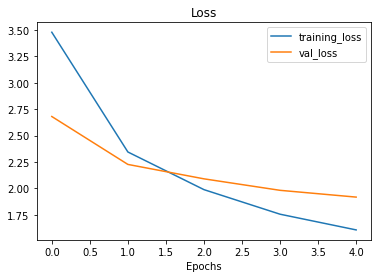

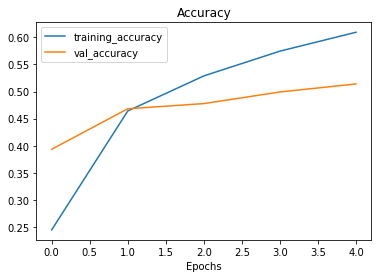

In [18]:
plot_loss_curves(history_all_classes_10_percent)

> **Question:** What do these curves suggest? Hint: ideally two curves should be very similar to each other, if not it may suggest that our model is ovefitting (perofrming too well on the training data and not generalizing to unseen data)

## Fine tuning

In [19]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [20]:
# Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fit)
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = ["accuracy"])

In [21]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name , layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [23]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [24]:
# Fine-tune for 5 more epochs 
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5)

# Fine tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs = fine_tune_epochs,
                                                     validation_data = test_data,
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 87s 332ms/step - loss: 1.3713 - accuracy: 0.6453 - val_loss: 1.8959 - val_accuracy: 0.5090
Epoch 6/10
237/237 [==============================] - 73s 304ms/step - loss: 1.2328 - accuracy: 0.6729 - val_loss: 1.9120 - val_accuracy: 0.5056
Epoch 7/10
237/237 [==============================] - 69s 288ms/step - loss: 1.1610 - accuracy: 0.6870 - val_loss: 1.8922 - val_accuracy: 0.5156
Epoch 8/10
237/237 [==============================] - 70s 292ms/step - loss: 1.1029 - accuracy: 0.7035 - val_loss: 1.8678 - val_accuracy: 0.5191
Epoch 9/10
237/237 [==============================] - 65s 270ms/step - loss: 1.0157 - accuracy: 0.7277 - val_loss: 1.8580 - val_accuracy: 0.5260
Epoch 10/10
237/237 [==============================] - 64s 268ms/step - loss: 0.9618 - accuracy: 0.7403 - val_loss: 1.8952 - val_accuracy: 0.5132


In [26]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 104s 131ms/step - loss: 1.6022 - accuracy: 0.5779


[1.6021664142608643, 0.5779010057449341]

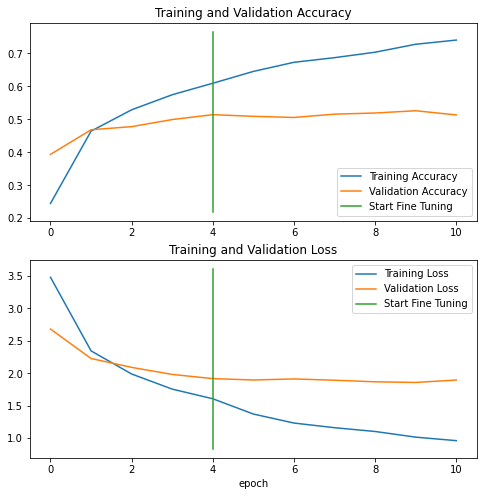

In [38]:
# Compare histories 
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs = 5)

## Saving and Loading our model
To use our model in an external application, we'll need to save it and export it somewhere

In [29]:
# Save our fine-tuning model
model.save("drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_saved_big_dog_model/assets


> **Note:** Loading the model with the following cell will output a large amount of warnings, there is a thread tracking this iussed on: https://github.com/tensorflow/tensorflow/issues/40166
however, it seems according to the TensorFlow documentation, loading warning can be ignored: https:// www.tensorflow.org/tutorials/keras/save_and_load#checkpoint_callback_usage


In [31]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/Colab Notebooks/101_food_classes_10_percent_saved_big_dog_model")

In [32]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 106s 132ms/step - loss: 1.6022 - accuracy: 0.5779


[1.6021664142608643, 0.5779010057449341]

In [33]:
# The results from our loaded model (above) should be very similar to our model
all_classes_10_percent_fine_tune_results

[1.6021664142608643, 0.5779010057449341]

## Evaluating the performance of the big dog model across all different classes


Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong

In [34]:

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


--2022-02-23 09:32:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  22.0MB/s    in 2.0s    

2022-02-23 09:32:31 (22.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [36]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [37]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [39]:
# Evaluate loaded model (the one we just download on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 106s 132ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027207851409912, 0.6077623963356018]

## Making predictions with our trained model


In [40]:
# Make predictions with our model
preds_probs = model.predict(test_data, verbose = 1) # set verbosity to see how long is left

790/790 [==============================] - 99s 123ms/step


In [42]:
# How many predictions are there?
len(preds_probs)

25250

In [43]:
len(preds_probs)/len(test_data)

31.962025316455698

In [44]:
# What is the shape of our predictions?
preds_probs.shape

(25250, 101)

In [45]:
# Let's see what the first 10 predictions look lie
preds_probs[:10]

array([[5.9541941e-02, 3.5742332e-06, 4.1376889e-02, ..., 1.4138899e-09,
        8.3530460e-05, 3.0897565e-03],
       [9.6401680e-01, 1.3753089e-09, 8.4779976e-04, ..., 5.4286684e-05,
        7.8363253e-12, 9.8467334e-10],
       [9.5925868e-01, 3.2534019e-05, 1.4867033e-03, ..., 7.1891884e-07,
        5.4398350e-07, 4.0276311e-05],
       ...,
       [4.7313324e-01, 1.2931301e-07, 1.4805583e-03, ..., 5.9749611e-04,
        6.6969820e-05, 2.3469329e-05],
       [4.4571780e-02, 4.7265351e-07, 1.2258515e-01, ..., 6.3498578e-06,
        7.5319103e-06, 3.6778715e-03],
       [7.2438985e-01, 1.9249777e-09, 5.2310857e-05, ..., 1.2291447e-03,
        1.5793171e-09, 9.6395503e-05]], dtype=float32)

In [48]:
# What does the first prediction probability array look like?
preds_probs[0],len(preds_probs[0]),sum(preds_probs[0])

(array([5.9541941e-02, 3.5742332e-06, 4.1376889e-02, 1.0660903e-09,
        8.1613996e-09, 8.6639682e-09, 8.0926134e-07, 8.5652442e-07,
        1.9858850e-05, 8.0977554e-07, 3.1727692e-09, 9.8673388e-07,
        2.8532100e-04, 7.8049661e-10, 7.4230990e-04, 3.8915794e-05,
        6.4740016e-06, 2.4977169e-06, 3.7891397e-05, 2.0678806e-07,
        1.5538471e-05, 8.1506892e-07, 2.6230925e-06, 2.0010653e-07,
        8.3827712e-07, 5.4215743e-06, 3.7391112e-06, 1.3150788e-08,
        2.7761345e-03, 2.8051816e-05, 6.8561651e-10, 2.5574524e-05,
        1.6688934e-04, 7.6409645e-10, 4.0452869e-04, 1.3150487e-08,
        1.7957433e-06, 1.4448400e-06, 2.3062853e-02, 8.2465459e-07,
        8.5366531e-07, 1.7138503e-06, 7.0526130e-06, 1.8402382e-08,
        2.8553984e-07, 7.9482870e-06, 2.0682012e-06, 1.8525193e-07,
        3.3619781e-08, 3.1522335e-04, 1.0410886e-05, 8.5448306e-07,
        8.4741890e-01, 1.0555387e-05, 4.4094719e-07, 3.7404192e-05,
        3.5306137e-05, 3.2489079e-05, 6.7313988e

Our  model  outpus a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed the predict method

In [51]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like :\n {preds_probs[0]}")
print(f"What is the predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like :
 [5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-05 1

In [52]:
test_data.class_names[52]

'gyoza'

In [53]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [54]:
# How many pred classes do we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions, to evaluate them, we need to compare them to original test dataset labels.

In [55]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [57]:
# To get our test labels we need to unlabel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # currently test labels look like : [0,0,0,1, ... ,0,0] we want the index value where the "1" occurs
labels[:10] # look at the first 10

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [58]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.


In [59]:
results_downloaded_model

[1.8027207851409912, 0.6077623963356018]

In [62]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)
sklearn_accuracy

0.6077623762376237

In [63]:
# Does this metrics come close to our model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

## Let's get visual: making a confusion matrix

In [64]:
from helper_functions import make_confusion_matrix

In [66]:
# Get a list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [74]:
# We need to make changes to our make_counfusion_matrix function to ensure the x-labels print vertically
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically)###

  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

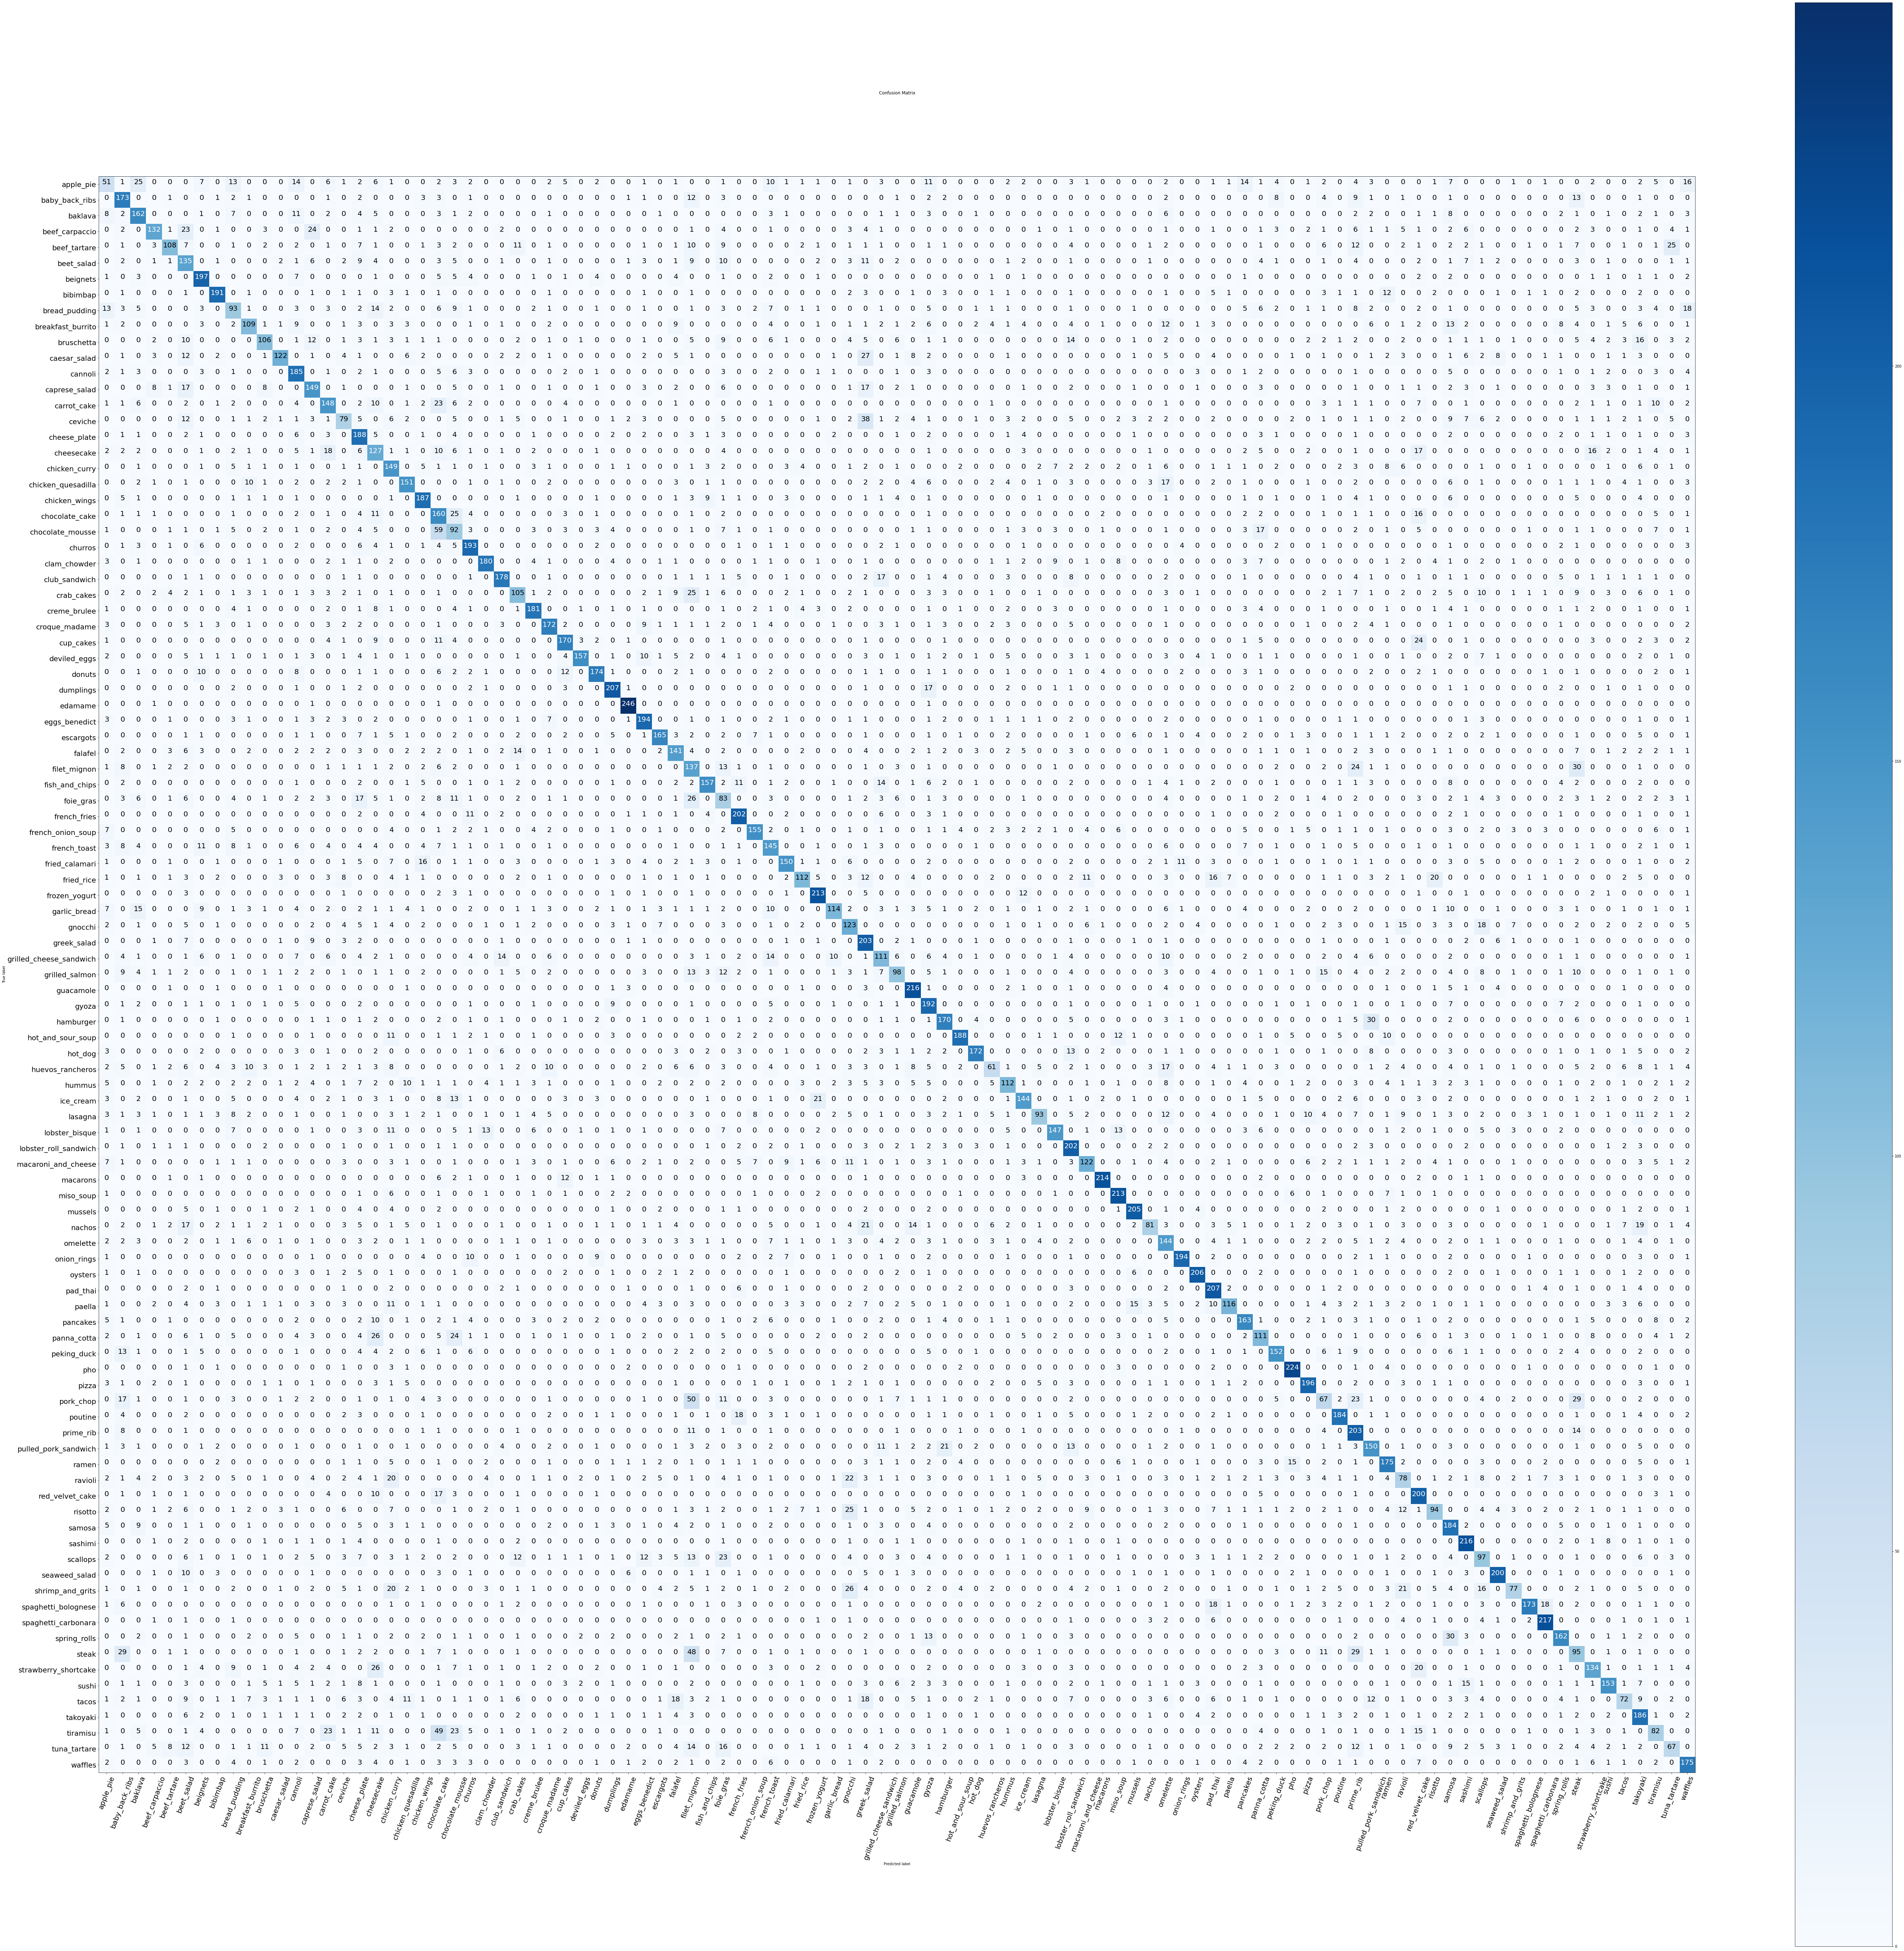

In [75]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = pred_classes,
                      classes= class_names,
                      figsize = (100,100),
                      text_size = 20,
                      savefig = True)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquiring many different classificatino metrics per class (e.g precision, recall and F1) called [classificatino_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 


In [76]:
from sklearn.metrics import classification_report
print(classification_report(y_true = y_labels,
                            y_pred = pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give a great class-by-class evaluation of model's predidctions but with so many classes, they're quite hard to understand
How about we create a visulization to get a better understanding?


In [84]:
# Get a dictionary of the classification reprot
classification_report_dict = classification_report(y_labels,pred_classes,output_dict = True)
# classificatino_report_dict

Let's plot all of our classes F1-scores...

In [82]:
classificatino_report_dict["99"]["f1-score"]

0.35356200527704484

In [88]:
# Create empty dictionary

class_f1_scores = {}

# Loop through classificatino report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]

class_f1_scores

TypeError: ignored

In [94]:
# Turn f1-scores into datafram for visualization

import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score" : list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)
f1_scores[:10]


class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

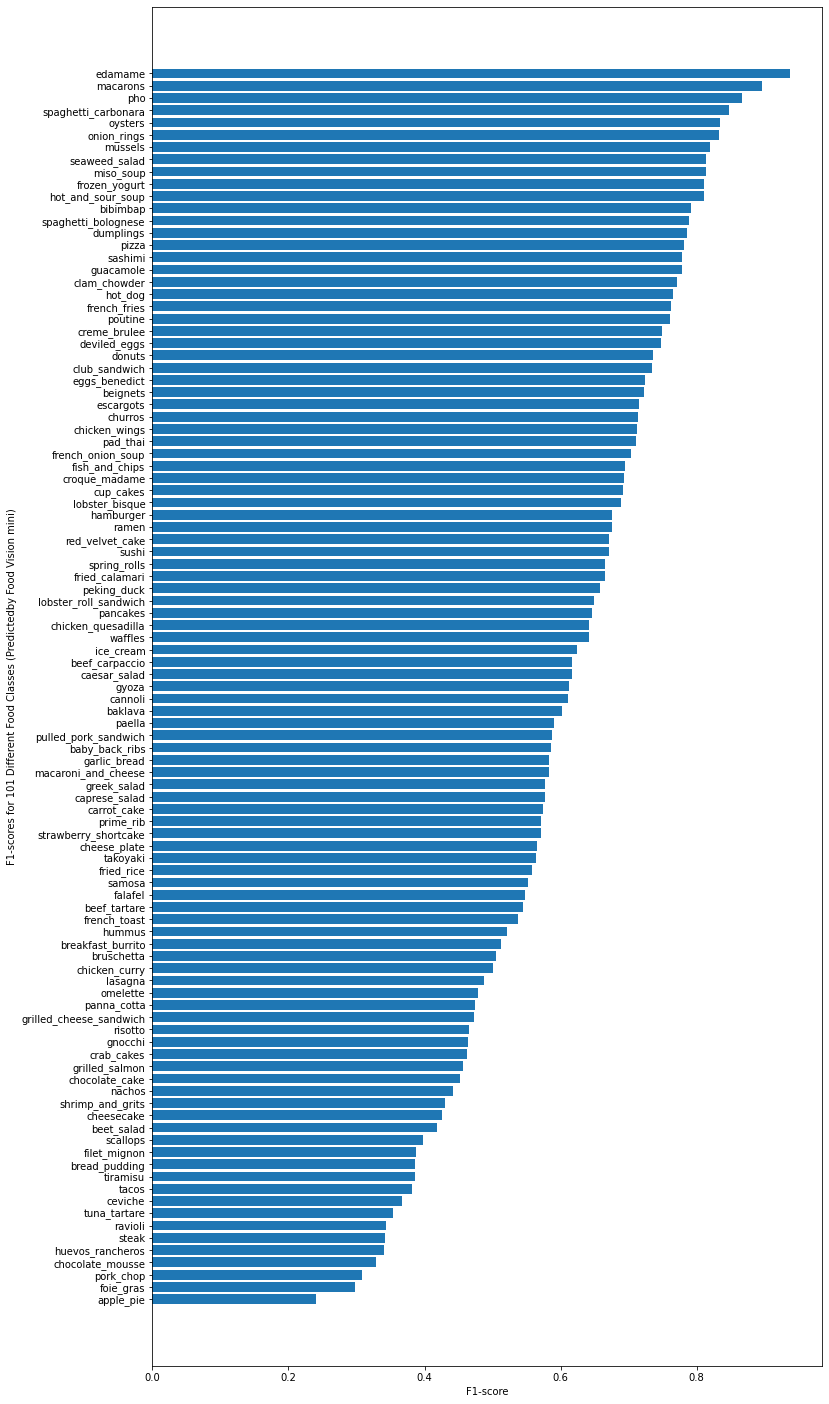

In [100]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (12,25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) # get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_ylabel("F1-scores for 101 Different Food Classes (Predictedby Food Vision mini)")
ax.invert_yaxis() # reverse the order of our plot

# Challenge: add values to the endof the each bar what the actual f1-score is 
# (hint: use the autolabel from here: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)


> **Exercise:** Try visualizing some of the most poorly predicted classes (e.g. `apple_pie,pork_chip`) do you notice any trends among them? Why might our model be having trouble with them

## Visualizing predictinos on custom images (test images)

Now, this is real test, how does our model go on food images not even in our test datset (images of our own)

To visualize our model's predictions on our own images, we'll need a functino to load and preprocess images, specifically it will need to:

* Read in a target image filepath using tf.io.read_file()
* Turn the image into a Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [101]:
# Create a functino to load and prepare images
def load_and_prep_image(filename,img_shape = 224,scale = True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape,3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not
  
  Returns:
    Image tensor of shape (img_shape,img_shape,3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img,channels = 3)

  # Resize the shape
  img = tf.image.resize(img,[img_shape,img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet Models in TensorFlow


Now we've got a function to load and prepare target images,
let's now write some code to visualize images, their target label and our model's predictions.


Specifically, write some code to:
1. Load a few random images from the test dataset
2. Make predictions on the loaded images
3. Plot the original image(s) along with the model's predictions, prediction probability and truth label


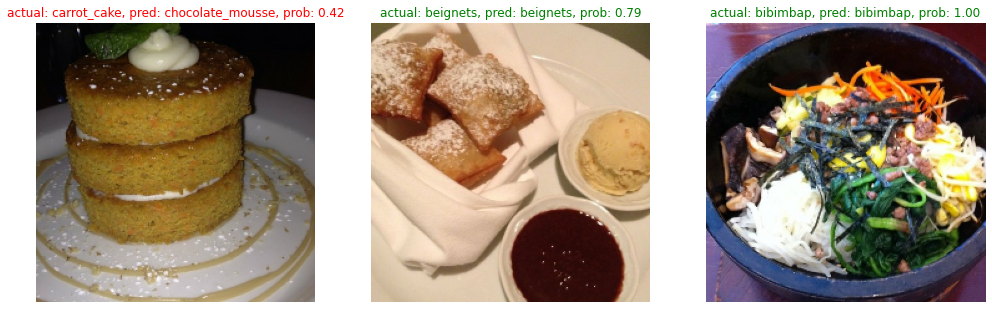

In [113]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize = (17,10))
for i in range(3):
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+"/"+class_name))
  filepath = test_dir + class_name + "/" + filename
  # print(filepath)

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale = False)
  img_expanded = tf.expand_dims(img,axis = 0)
  pred_prob = model.predict(img_expanded) # get predictino probabilities array
  pred_class = class_names[pred_prob.argmax()] # Get highest prediction probability index and match i class_name list
  # print(pred_prob)
  # print(pred_class)

  # Plot the image
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)

  if class_name == pred_class: # if predicted class matches truth class, make text green
    title_color = "g"
  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c = title_color)
  plt.axis(False)


In [106]:
test_dir

'101_food_classes_10_percent/test'

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:
1. Get all of the image file paths in the test dataset using [list_files()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) method
2. Create a pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max prediction probaibilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [117]:
# Get all of the image file paths in the test dataset
filepaths = []


for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                shuffle = False):
  filepaths.append(filepath.numpy())
filepaths[:10]


[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [119]:
# 2. Create a DataFrame of different parameters for each of our test images
pred_df = pd.DataFrame({"img_path": filepaths,
                       "y_true": y_labels,
                       "y_pred": pred_classes,
                       "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability values
                       "y_true_classname": [class_names[i] for i in y_labels],
                       "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  ...      y_pred_classname
0      b'/content/101_food_classes_10_percent/test/ap...  ...                 gyoza
1      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
2      b'/content/101_food_classes_10_percent/test/ap...  ...             apple_pie
3      b'/content/101_food_classes_10_percent/test/ap...  ...  pulled_pork_sandwich
4      b'/content/101_food_classes_10_percent/test/ap...  ...             prime_rib
...                                                  ...  ...                   ...
25245  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25246  b'/content/101_food_classes_10_percent/test/wa...  ...          cheese_plate
25247  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles
25248  b'/content/101_food_classes_10_percent/test/wa...  ...  strawberry_shortcake
25249  b'/content/101_food_classes_10_percent/test/wa...  ...               waffles

[25250 rows x 6 columns]

In [120]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct" ] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  ...  pred_correct
0  b'/content/101_food_classes_10_percent/test/ap...  ...         False
1  b'/content/101_food_classes_10_percent/test/ap...  ...          True
2  b'/content/101_food_classes_10_percent/test/ap...  ...          True
3  b'/content/101_food_classes_10_percent/test/ap...  ...         False
4  b'/content/101_food_classes_10_percent/test/ap...  ...         False

[5 rows x 7 columns]

In [122]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending = False)[:100]
top_100_wrong.head(20)

img_path  ...  pred_correct
21810  b'/content/101_food_classes_10_percent/test/sc...  ...         False
231    b'/content/101_food_classes_10_percent/test/ap...  ...         False
15359  b'/content/101_food_classes_10_percent/test/lo...  ...         False
23539  b'/content/101_food_classes_10_percent/test/st...  ...         False
21400  b'/content/101_food_classes_10_percent/test/sa...  ...         False
24540  b'/content/101_food_classes_10_percent/test/ti...  ...         False
2511   b'/content/101_food_classes_10_percent/test/br...  ...         False
5574   b'/content/101_food_classes_10_percent/test/ch...  ...         False
17855  b'/content/101_food_classes_10_percent/test/pa...  ...         False
23797  b'/content/101_food_classes_10_percent/test/su...  ...         False
18001  b'/content/101_food_classes_10_percent/test/pa...  ...         False
11642  b'/content/101_food_classes_10_percent/test/ga...  ...         False
10847  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23631  b'/content/101_food_classes_10_percent/test/st...  ...         False
1155   b'/content/101_food_classes_10_percent/test/be...  ...         False
10854  b'/content/101_food_classes_10_percent/test/fr...  ...         False
23904  b'/content/101_food_classes_10_percent/test/su...  ...         False
7316   b'/content/101_food_classes_10_percent/test/cu...  ...         False
13144  b'/content/101_food_classes_10_percent/test/gy...  ...         False
10880  b'/content/101_food_classes_10_percent/test/fr...  ...         False

[20 rows x 7 columns]

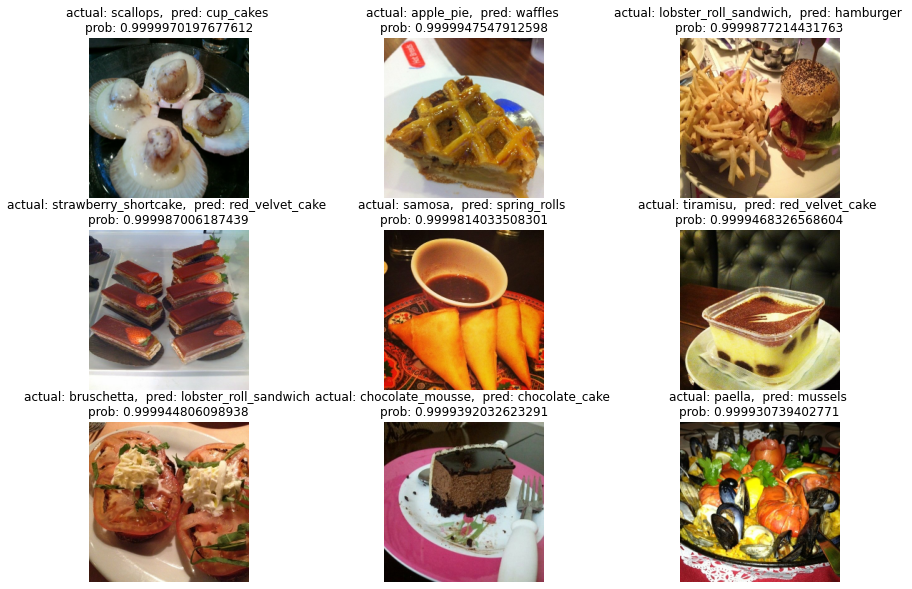

In [126]:
# 5. Visualize the tset data sample which have the wrong prediction but highes pred
images_to_view = 9
start_index = 0
plt.figure(figsize =(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index + images_to_view].itertuples()):
  # print(row)
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1], scale = False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname},  pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)

## Test out the big dog model on our own custom images

In [128]:
# Get custom images 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2022-02-23 13:33:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  32.8MB/s    in 0.4s    

2022-02-23 13:33:58 (32.8 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [142]:
# Get the custom food images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
my_food_dir = ["/content/20210617_152631.jpg"]

In [143]:
custom_food_images

['custom_food_images/chicken_wings.jpeg',
 'custom_food_images/20210617_152631.jpg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza.jpg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/bread.jpg']

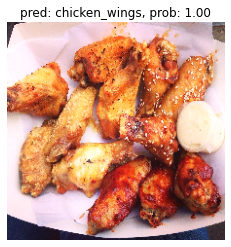

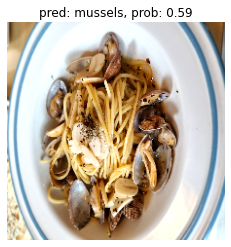

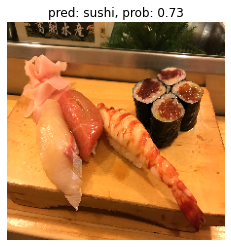

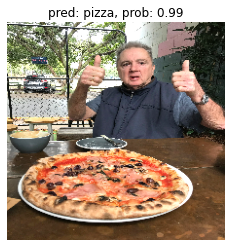

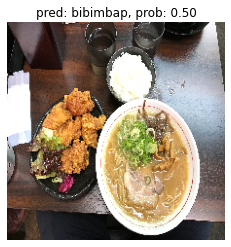

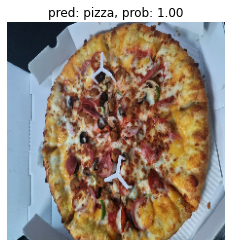

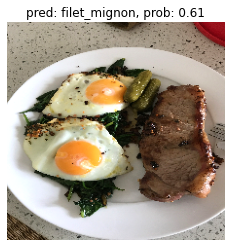

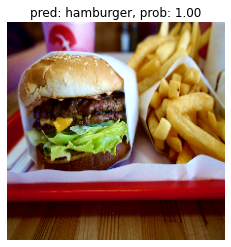

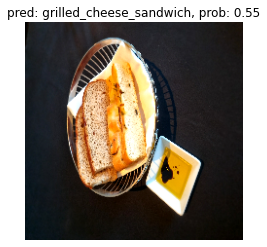

In [144]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img,scale = False) # don't need to scale for our EfficientNetB0
  pred_prob = model.predict(tf.expand_dims(img,axis=0)) # make prediction on image with shape [1,224,224,3] (same shape as the trained image)
  pred_class = class_names[pred_prob.argmax()] # get the index with the highest prediction probability
  # Plot the appropriate inforamtion
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)